In [0]:
# Import TensorFlow and enable eager execution
# This code requires TensorFlow version >=1.9
import tensorflow as tf
tf.enable_eager_execution()

# We'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [0]:
annotation_zip = tf.keras.utils.get_file('captions.zip', 
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
  image_zip = tf.keras.utils.get_file(name_of_zip, 
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip)+'/train2014/'
else:
  PATH = os.path.abspath('.')+'/train2014/'

13510574080/13510573713 [==============================] - 219s 0us/step


In [0]:
with open(annotation_file, 'r') as f:
  annotations = json.load(f)
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
  caption = '<start> ' + annot['caption'] + ' <end>'
  image_id = annot['image_id']
  full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)
  
  all_img_name_vector.append(full_coco_image_path)
  all_captions.append(caption)

train_captions, img_name_vector = shuffle(all_captions, all_img_name_vector, random_state = 1)

num_example = 50000
train_captions = train_captions[:num_example]
img_name_vector = img_name_vector[:num_example]

In [0]:
len(train_captions), len(img_name_vector)

(100000, 100000)

In [0]:
def load_image(image_path):
  img = tf.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels = 3)#color
  img = tf.image.resize_images(img, (299,299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

In [0]:
image_model = tf.keras.applications.InceptionV3(include_top = False,
                                               weights = 'imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [0]:
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train).map(load_image).batch(16)



In [0]:
from tqdm import tqdm
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features, 
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())


3874it [14:10,  3.22it/s]


In [0]:
def calc_max_length(tensor):
  return max(len(t) for t in tensor)

In [0]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)


In [0]:
tokenizer.word_index['<pad>'] = 0

In [0]:
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [0]:
max_length = calc_max_length(train_seqs)

In [0]:
img_name_train,img_name_val,cap_train,cap_val = train_test_split(img_name_vector,
                                                                cap_vector,
                                                                test_size=0.2,
                                                                random_state=0)

In [0]:
len(img_name_train), len(img_name_val), len(cap_train), len(cap_val)

(80000, 20000, 80000, 20000)

In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index)
features_shape = 2048
attention_features_shape = 64

In [0]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.py_func(
    map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=2)

In [0]:
dataset = dataset.shuffle(BUFFER_SIZE)

dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(1)

In [0]:
def gru(units):
  if tf.test.is_gpu_available():
    return tf.keras.layers.CuDNNGRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
  else:
    return tf.keras.layers.GRU(units,
                              return_sequences=True,
                              return_state=True,
                              recurrent_activation='sigmoid',
                              recurrent_initializer='glorot_uniform')
  

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  def call(self, features, hidden):
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    
    
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis = 1)
    return context_vector, attention_weights


In [0]:
class CNN_Encoder(tf.keras.Model):
  def __init__(self, embedding_dim):
    super(CNN_Encoder, self).__init__()
    
    self.fc = tf.keras.layers.Dense(embedding_dim)
    
  def call(self,x):
    x = self.fc(x)
    x = tf.nn.relu(x)
    return x

In [0]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units
    
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = gru(self.units)
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    
    self.attention = BahdanauAttention(self.units)
    
  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)
    
    x = self.embedding(x)
    
    x = tf.concat([tf.expand_dims(context_vector,1),x], axis = -1)
    
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)
    
    return x, state, attention_weights
  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
optimizer = tf.train.AdamOptimizer()

def loss_function(real, pred):
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred)
  return tf.reduce_mean(loss_)

In [0]:
loss_plot = []


In [0]:
EPOCHS = 20
for epoch in range(EPOCHS):
  start = time.time()
  total_loss = 0
  
  for (batch, (img_tensor, target)) in enumerate(dataset):
    loss = 0
    
    hidden = decoder.reset_state(batch_size=target.shape[0])
    
    dec_input = tf.expand_dims([tokenizer.word_index['start']]*BATCH_SIZE,1)
    
    with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      
      for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        
        loss += loss_function(target[:,i], predictions)
        
        dec_input = tf.expand_dims(target[:,i],1)
    total_loss += (loss/int(target.shape[1]))
    variables = encoder.variables + decoder.variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables), tf.train.get_or_create_global_step())
    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch+1,batch,loss.numpy()/int(target.shape[1])))
  loss_plot.append(total_loss/len(cap_vector))
  print('Epoch {} Loss {:.6f}'.format(epoch+1, total_loss/len(cap_vector)))
  print('Time Taken for 1 epoch {} sec\n'.format(time.time()-start))

In [0]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [0]:
def evaluate(image):
  attention_plot = np.zeros((max_length, attention_features_shape))
  
  hidden = decoder.reset_state(batch_size=1)
  
  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  
  features = encoder(img_tensor_val)
  
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']],0)
  result = []
  
  for i in range(max_length):
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
    
    attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
    
    predicted_id = tf.argmax(predictions[0]).numpy()
    result.append(tokenizer.index_word[predicted_id])
    
    if tokenizer.index_word[predicted_id] == '<end>':
      return result, attention_plot
    dec_input = tf.expand_dims([predicted_id], 0)
    
  attention_plot = attention_plot[:len(result),:]
  return result, attention_plot
    

In [0]:
def reevaluate(image):
  hidden = decoder.reset_state(batch_size=1)
  
  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
  
  features = encoder(img_tensor_val)
  
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']],0)
  result = []
  
  for i in range(max_length):
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
    predicted_id = tf.argmax(predictions[0]).numpy()
    result.append(tokenizer.index_word[predicted_id])
    if tokenizer.index_word[predicted_id] == '<end>':
      return result
    dec_input = tf.expand_dims([predicted_id], 0)
  return result

In [0]:
def plot_attention(image, result, attention_plot):
  temp_image = np.array(Image.open(image))
  
  fig = plt.figure(figsize=(10,10))
  
  len_result = len(result)
  for l in range(len_result):
    temp_att = np.resize(attention_plot[l], (8,8))
    ax = fig.add_subplot(len_result//2, len_result//2, l+1)
    ax.set_title(result[l])
    img = ax.imshow(temp_image)
    ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
  plt.tight_layout()
  plt.show()
  
    

Real Caption: <start> a black cat and a black cat statue in a window sill <end>
Predicted Caption: sitting next to a dog in a eatery <end>


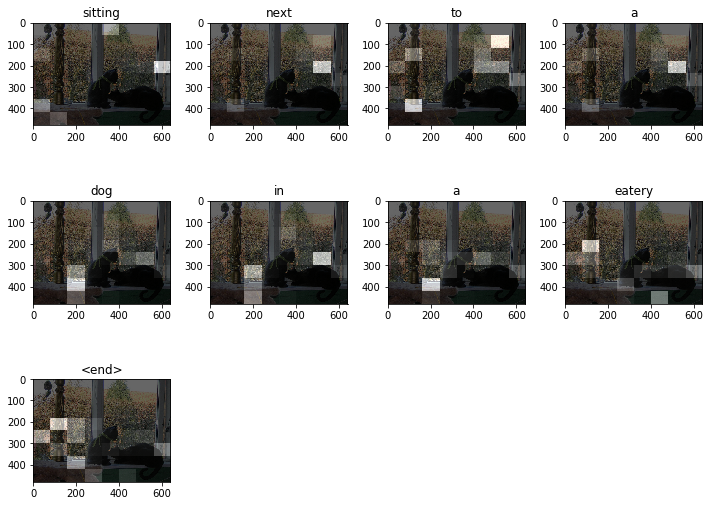

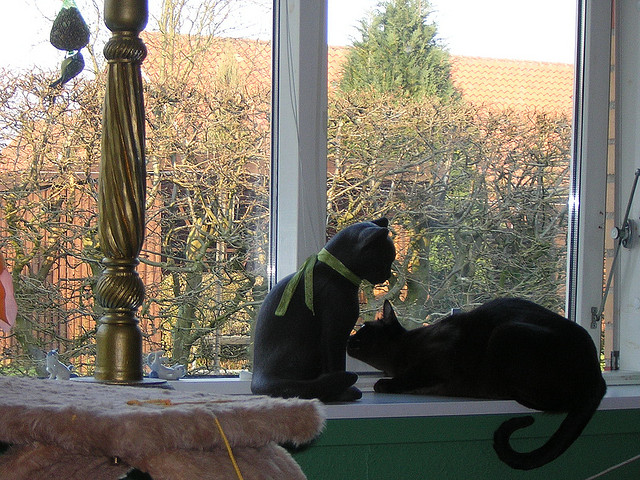

In [0]:
rid = np.random.randint(0, len(img_name_val))

image = img_name_val[rid]


real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Predicted Caption:', ' '.join(result))
plot_attention(image,result,attention_plot)

Image.open(img_name_val[rid])

In [0]:
reals=[]
predicted=[]

for j in range(len(img_name_val)):
  image = img_name_val[j]
  real_cap = [tokenizer.index_word[i] for i in cap_val[j] if i not in [0,3,4]] #0:pad, 3: start, 4:end
  result= reevaluate(image)
  reals.append(real_cap)
  predicted.append(result[:-1])
  if j % 100 == 0:
    print(j)
    

In [0]:
from nltk.translate.bleu_score import sentence_bleu
scores=[]
for i in range(len(reals)):
  score=np.zeros(4)
  reference = [reals[i]]
  candidate = predicted[i]
  score[0] = sentence_bleu(reference, candidate,weights = (1,0,0,0))
  score[1] = sentence_bleu(reference, candidate,weights = (0.5,0.5,0,0))
  score[2] = sentence_bleu(reference, candidate,weights = (0.33,0.33,0.33,0))
  score[3] = sentence_bleu(reference, candidate,weights = (0.25,0.25,0.25,0.25))
  scores.append(score)


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [0]:
import numpy as np
scores = np.array(scores)
scores.shape
for i in range(scores.shape[1]):
  print(np.sum(scores[:,i]/scores.shape[0]))

0.1950259685192839
0.2454415888572842
0.31596459307521124
0.36704276601526004


In [0]:
import pickle
truth_file = open('ground_truth_6000_423.pickle', 'wb')
pickle.dump(reals, truth_file)
truth_file.close()
pred_file = open('predicted_val_6000_423.pickle','wb')
pickle.dump(predicted, pred_file)
pred_file.close()